In [14]:
"""
ClimateWins Deep Learning Project - CNN Model
Task: Predict pleasant weather patterns using 60 years of weather data
Author: David Scheider
Date: 2025

This script follows the HAR (Human Activity Recognition) example structure
to build a CNN model for weather prediction across 15 European weather stations.
"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("CLIMATEWINS DEEP LEARNING PROJECT - CNN MODEL")
print("="*80)


CLIMATEWINS DEEP LEARNING PROJECT - CNN MODEL


In [15]:
# ==============================================================================
# TASK 1: LOAD UNSCALED WEATHER OBSERVATIONS AND PLEASANT WEATHER
# ==============================================================================
print("\nTASK 1: Loading unscaled weather data...")
print("-"*80)

weather_obs = pd.read_csv('/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-weather-prediction-dataset-processed.csv')
pleasant_weather = pd.read_csv('/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

print(f"Weather observations shape: {weather_obs.shape}")
print(f"Pleasant weather shape: {pleasant_weather.shape}")
print("✓ Data loaded successfully")


TASK 1: Loading unscaled weather data...
--------------------------------------------------------------------------------
Weather observations shape: (22950, 170)
Pleasant weather shape: (22950, 16)
✓ Data loaded successfully


In [16]:
# ==============================================================================
# TASK 2: MODEL SELECTION - CNN vs RNN
# ==============================================================================
print("\n" + "="*80)
print("TASK 2: MODEL SELECTION - WHY CNN?")
print("="*80)

model_choice = """
CHOICE: Convolutional Neural Network (CNN)

REASONING:
1. SPATIAL PATTERNS: Weather data contains spatial patterns across different 
   observation types (temperature, humidity, pressure, etc.). CNNs excel at 
   detecting spatial relationships and patterns within structured data.

2. FEATURE EXTRACTION: CNNs automatically learn hierarchical features from the 
   raw weather observations. The convolutional layers can identify local patterns 
   (e.g., temperature-humidity relationships) that are relevant for predicting 
   pleasant weather conditions.

3. DIMENSIONALITY: With 9 observation types per station and 15 stations, CNNs 
   can efficiently process this multi-dimensional data through their convolution 
   and pooling operations.

4. COMPUTATIONAL EFFICIENCY: CNNs are generally faster to train than RNNs/LSTMs 
   for this type of structured numerical data, especially when temporal sequence 
   is less critical than spatial relationships.

5. PROVEN SUCCESS: The HAR smartphone example showed CNNs achieving 97%+ 
   accuracy on similar multi-dimensional sensor data, making it a reliable 
   choice for weather pattern recognition.

While RNNs would be better for pure time-series forecasting, this task focuses 
on pattern recognition across multiple weather stations simultaneously, where 
CNNs are more appropriate.
"""

print(model_choice)



TASK 2: MODEL SELECTION - WHY CNN?

CHOICE: Convolutional Neural Network (CNN)

REASONING:
1. SPATIAL PATTERNS: Weather data contains spatial patterns across different 
   observation types (temperature, humidity, pressure, etc.). CNNs excel at 
   detecting spatial relationships and patterns within structured data.

2. FEATURE EXTRACTION: CNNs automatically learn hierarchical features from the 
   raw weather observations. The convolutional layers can identify local patterns 
   (e.g., temperature-humidity relationships) that are relevant for predicting 
   pleasant weather conditions.

3. DIMENSIONALITY: With 9 observation types per station and 15 stations, CNNs 
   can efficiently process this multi-dimensional data through their convolution 
   and pooling operations.

4. COMPUTATIONAL EFFICIENCY: CNNs are generally faster to train than RNNs/LSTMs 
   for this type of structured numerical data, especially when temporal sequence 
   is less critical than spatial relationships.

5. 

In [17]:
# ==============================================================================
# TASK 3: DATA CLEANING AND PREPARATION
# ==============================================================================
print("\n" + "="*80)
print("TASK 3: DATA CLEANING AND STRUCTURING")
print("="*80)

# Step 3.1: Drop DATE and MONTH columns
print("\nStep 3.1: Dropping DATE and MONTH columns...")
X = weather_obs.drop(columns=['DATE', 'MONTH'])
y = pleasant_weather.drop(columns=['DATE'])

print(f"  X shape after dropping DATE/MONTH: {X.shape}")
print(f"  y shape after dropping DATE: {y.shape}")

# Step 3.2: Remove stations with insufficient data
print("\nStep 3.2: Removing stations with insufficient data...")
stations_to_remove = ['GDANSK', 'ROMA', 'TOURS']
print(f"  Stations to remove: {stations_to_remove}")

cols_to_drop = [col for col in X.columns if any(station in col for station in stations_to_remove)]
X = X.drop(columns=cols_to_drop)
print(f"  X shape after removing stations: {X.shape}")
print(f"  Removed {len(cols_to_drop)} columns")

# Step 3.3: Remove observation types with missing data for multiple years
print("\nStep 3.3: Identifying observation types to remove...")
print("  Analysis shows:")
print("    - cloud_cover: 14/15 stations (1 missing)")
print("    - wind_speed: 9/15 stations (6 missing)")
print("    - snow_depth: 6/15 stations (9 missing)")
print("  → Removing: wind_speed and snow_depth")

obs_to_remove = ['wind_speed', 'snow_depth']
cols_to_drop = [col for col in X.columns if any(obs in col for obs in obs_to_remove)]
X = X.drop(columns=cols_to_drop)
print(f"  X shape after removing observation types: {X.shape}")
print(f"  Removed {len(cols_to_drop)} columns")

# Check which station is missing cloud_cover
print("\n  Checking for missing cloud_cover...")
stations_remaining = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 
                      'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 
                      'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

for station in stations_remaining:
    cloud_col = f"{station}_cloud_cover"
    if cloud_col not in X.columns:
        print(f"  → {station} is missing cloud_cover")
        # Add column with mean of other stations' cloud_cover
        other_cloud_cols = [col for col in X.columns if 'cloud_cover' in col]
        X[cloud_col] = X[other_cloud_cols].mean(axis=1)
        print(f"  → Added {cloud_col} with mean values from other stations")

print(f"  X shape after adding missing cloud_cover: {X.shape}")

# Step 3.4: Fill in 3 missing individual observations
print("\nStep 3.4: Filling missing individual observations...")
print("  Note: Task mentions Ljubljana→Kassel, Sonnblick→München, Oslo→Stockholm")
print("  Current analysis shows no missing values in remaining data")
print("  This step may have been completed in preprocessing")

# Verify no missing values
missing_count = X.isnull().sum().sum()
print(f"  Total missing values in X: {missing_count}")

if missing_count > 0:
    print("  WARNING: Missing values detected. Review data cleaning!")
else:
    print("  ✓ No missing values found")

# Step 3.5: Verify final shapes and determine actual dimensions
print("\nStep 3.5: Verifying and adjusting to actual data shape...")
print(f"  Current X shape: {X.shape}")
print(f"  Current y shape: {y.shape}")
print(f"  Original target: (22950, 135) = 15 stations × 9 observations")

# Calculate actual dimensions
n_rows = X.shape[0]
n_cols = X.shape[1]
n_stations = 15

# Determine observations per station
if n_cols % n_stations == 0:
    obs_per_station = n_cols // n_stations
    print(f"  ✓ Actual: {n_cols} columns = {n_stations} stations × {obs_per_station} observations")
else:
    # Columns don't divide evenly - we'll need to adjust
    obs_per_station = n_cols // n_stations
    remainder = n_cols % n_stations
    print(f"  ⚠ {n_cols} columns don't divide evenly by {n_stations} stations")
    print(f"    {obs_per_station} observations per station + {remainder} extra columns")
    print(f"  → We'll pad with zeros to make it even")
    
    # Add padding columns to make it divisible
    needed_cols = (obs_per_station + 1) * n_stations - n_cols
    for i in range(needed_cols):
        X[f'PADDING_{i}'] = 0
    
    obs_per_station += 1
    print(f"  ✓ Added {needed_cols} padding columns")
    print(f"  ✓ New shape: {X.shape} = {n_stations} stations × {obs_per_station} observations")

# Store these for later use
final_obs_per_station = obs_per_station
final_n_cols = n_stations * obs_per_station

print(f"  ✓ Final dimensions for reshape: ({n_rows}, {n_stations}, {final_obs_per_station})")

# Step 3.6: Export cleaned data
print("\nStep 3.6: Exporting cleaned dataset...")
X_export = X.copy()
X_export.insert(0, 'DATE', weather_obs['DATE'])
X_export.insert(1, 'MONTH', weather_obs['MONTH'])

y_export = y.copy()
y_export.insert(0, 'DATE', pleasant_weather['DATE'])

X_export.to_csv('/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-weather-prediction-dataset-CLEANED.csv', index=False)
y_export.to_csv('/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-Answers-Weather_Prediction_Pleasant_Weather-CLEANED.csv', index=False)

print("  ✓ Cleaned datasets exported")
print("    - Dataset-weather-prediction-dataset-CLEANED.csv")
print("    - Dataset-Answers-Weather_Prediction_Pleasant_Weather-CLEANED.csv")



TASK 3: DATA CLEANING AND STRUCTURING

Step 3.1: Dropping DATE and MONTH columns...
  X shape after dropping DATE/MONTH: (22950, 168)
  y shape after dropping DATE: (22950, 15)

Step 3.2: Removing stations with insufficient data...
  Stations to remove: ['GDANSK', 'ROMA', 'TOURS']
  X shape after removing stations: (22950, 147)
  Removed 21 columns

Step 3.3: Identifying observation types to remove...
  Analysis shows:
    - cloud_cover: 14/15 stations (1 missing)
    - wind_speed: 9/15 stations (6 missing)
    - snow_depth: 6/15 stations (9 missing)
  → Removing: wind_speed and snow_depth
  X shape after removing observation types: (22950, 132)
  Removed 15 columns

  Checking for missing cloud_cover...
  → KASSEL is missing cloud_cover
  → Added KASSEL_cloud_cover with mean values from other stations
  X shape after adding missing cloud_cover: (22950, 133)

Step 3.4: Filling missing individual observations...
  Note: Task mentions Ljubljana→Kassel, Sonnblick→München, Oslo→Stockholm


In [18]:
# ==============================================================================
# TASK 4: RESHAPE DATA FOR DEEP LEARNING MODEL
# ==============================================================================
print("\n" + "="*80)
print("TASK 4: RESHAPING DATA FOR CNN INPUT")
print("="*80)

print("\nReshaping X based on actual dimensions...")
print(f"  Target: ({n_rows}, {n_stations}, {final_obs_per_station})")

# Convert to numpy arrays
X_array = X.values
y_array = y.values

# Reshape X using actual dimensions
X_reshaped = X_array.reshape(-1, n_stations, final_obs_per_station)

print(f"  Original X shape: {X_array.shape}")
print(f"  Reshaped X shape: {X_reshaped.shape}")
print(f"  y shape (no reshape needed): {y_array.shape}")

# Verify
assert X_reshaped.shape[0] == n_rows, "Row count mismatch!"
assert X_reshaped.shape[1] == n_stations, "Station count mismatch!"
assert X_reshaped.shape[2] == final_obs_per_station, "Observation count mismatch!"
assert y_array.shape == (n_rows, n_stations), "y shape incorrect!"
print("  ✓ Reshape successful!")



TASK 4: RESHAPING DATA FOR CNN INPUT

Reshaping X based on actual dimensions...
  Target: (22950, 15, 9)
  Original X shape: (22950, 135)
  Reshaped X shape: (22950, 15, 9)
  y shape (no reshape needed): (22950, 15)
  ✓ Reshape successful!


In [19]:
# ==============================================================================
# TASK 5: SPLIT DATA INTO TRAINING AND TEST SETS
# ==============================================================================
print("\n" + "="*80)
print("TASK 5: SPLITTING DATA (70% TRAIN, 30% TEST)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_array, 
    test_size=0.3, 
    random_state=42
)

print(f"Training set X shape: {X_train.shape}")
print(f"Training set y shape: {y_train.shape}")
print(f"Test set X shape: {X_test.shape}")
print(f"Test set y shape: {y_test.shape}")
print("✓ Data split complete")


TASK 5: SPLITTING DATA (70% TRAIN, 30% TEST)
Training set X shape: (16065, 15, 9)
Training set y shape: (16065, 15)
Test set X shape: (6885, 15, 9)
Test set y shape: (6885, 15)
✓ Data split complete


In [21]:
# ==============================================================================
# TASK 6: BUILD KERAS CNN MODEL
# ==============================================================================
print("\n" + "="*80)
print("TASK 6: BUILDING KERAS CNN MODEL")
print("="*80)

print("\nModel Architecture (based on HAR CNN example):")
print("-"*80)

# Define hyperparameters
epochs = 30
batch_size = 32
n_hidden = 32  # Start small, can increase to 64, 128, etc.

# Extract dimensions from data
timesteps = X_train.shape[1]  # Number of stations
input_dim = X_train.shape[2]  # Number of observations per station
n_classes = y_train.shape[1]  # Number of output classes (15 stations)

print(f"Hyperparameters:")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Hidden layers (filters): {n_hidden}")
print(f"  - Input shape: ({timesteps}, {input_dim})")
print(f"  - Output classes: {n_classes}")

# Build Sequential model
model = Sequential()

# Layer 1: Convolutional layer
model.add(Conv1D(
    filters=n_hidden,
    kernel_size=2,
    activation='relu',
    input_shape=(timesteps, input_dim)
))

# Layer 2: Dense layer
model.add(Dense(16, activation='relu'))

# Layer 3: Max Pooling
model.add(MaxPooling1D(pool_size=2))

# Layer 4: Flatten
model.add(Flatten())

# Layer 5: Output layer
model.add(Dense(n_classes, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',  # For multi-label classification
    optimizer='adam',
    metrics=['accuracy']
)

print("\nModel Summary:")
print("-"*80)
model.summary()



TASK 6: BUILDING KERAS CNN MODEL

Model Architecture (based on HAR CNN example):
--------------------------------------------------------------------------------
Hyperparameters:
  - Epochs: 30
  - Batch size: 32
  - Hidden layers (filters): 32
  - Input shape: (15, 9)
  - Output classes: 15

Model Summary:
--------------------------------------------------------------------------------


/opt/anaconda3/envs/climate_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 32)         │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ==============================================================================
# TASK 7: COMPILE AND RUN MODEL
# ==============================================================================
print("\n" + "="*80)
print("TASK 7: TRAINING THE MODEL")
print("="*80)

print(f"\nTraining for {epochs} epochs with batch size {batch_size}...")
print("Watch the loss decrease and accuracy increase:\n")

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

# Evaluate on test set
print("\n" + "-"*80)
print("EVALUATING ON TEST SET:")
print("-"*80)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\nFinal Test Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Record hyperparameters for documentation
print("\n" + "="*80)
print("HYPERPARAMETER SUMMARY FOR DOCUMENTATION")
print("="*80)
print(f"""
STARTING HYPERPARAMETERS:
  - Model Type: CNN (Convolutional Neural Network)
  - Epochs: {epochs}
  - Batch Size: {batch_size}
  - Filters (Conv1D): {n_hidden}
  - Dense Layer Size: 16
  - Kernel Size: 2
  - Pool Size: 2
  - Activation Functions: relu (hidden), sigmoid (output)
  - Loss Function: binary_crossentropy
  - Optimizer: adam

FINAL RESULTS:
  - Training Loss: {history.history['loss'][-1]:.4f}
  - Training Accuracy: {history.history['accuracy'][-1]:.4f}
  - Test Loss: {test_loss:.4f}
  - Test Accuracy: {test_accuracy:.4f}
""")



TASK 7: TRAINING THE MODEL

Training for 30 epochs with batch size 32...
Watch the loss decrease and accuracy increase:

Epoch 1/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.1302 - loss: 0.3263 - val_accuracy: 0.1668 - val_loss: 0.2441
Epoch 2/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.1741 - loss: 0.2350 - val_accuracy: 0.1780 - val_loss: 0.2193
Epoch 3/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.1736 - loss: 0.2160 - val_accuracy: 0.1743 - val_loss: 0.2072
Epoch 4/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.1688 - loss: 0.2056 - val_accuracy: 0.1768 - val_loss: 0.1999
Epoch 5/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.1667 - loss: 0.1987 - val_accuracy: 0.1749 - val_loss: 0.1949
Epoch 6/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.1677 - loss: 0.1937 - val_accuracy: 0.1740 - val_loss: 0.1912
Epoch 7/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.1694 - loss: 0.1897 - val_accu


TASK 8: CONFUSION MATRIX AND EVALUATION
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step

Confusion Matrix per Station:
--------------------------------------------------------------------------------
BASEL       : 91.27% accuracy
BELGRADE    : 91.33% accuracy
BUDAPEST    : 91.42% accuracy
DEBILT      : 93.52% accuracy
DUSSELDORF  : 92.80% accuracy
HEATHROW    : 92.65% accuracy
KASSEL      : 94.20% accuracy
LJUBLJANA   : 91.24% accuracy
MAASTRICHT  : 93.26% accuracy
MADRID      : 92.10% accuracy
MUNCHENB    : 95.35% accuracy
OSLO        : 95.99% accuracy


/opt/anaconda3/envs/climate_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


SONNBLICK   : 100.00% accuracy
STOCKHOLM   : 93.32% accuracy
VALENTIA    : 96.99% accuracy

✓ Confusion matrix saved: confusion_matrix_all_stations.png

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE:
--------------------------------------------------------------------------------
Total predictions: 103,275
Correct predictions: 96,765
Overall accuracy: 93.70%

Stations with at least one 'pleasant' prediction: 14/15

MODEL TRAINING COMPLETE

NEXT STEPS:
1. Save screenshots of:
   - Model summary
   - Training progress (loss/accuracy)
   - Final confusion matrices
   
2. Document hyperparameters in a separate file

3. Try adjusting hyperparameters to improve performance:
   - Increase epochs (50, 100)
   - Increase filters (64, 128)
   - Add more Conv1D layers
   - Adjust batch size (16, 64)
   
4. Save this script - you'll use it in Exercise 2.4!


✓ Training history plot saved: training_history.png


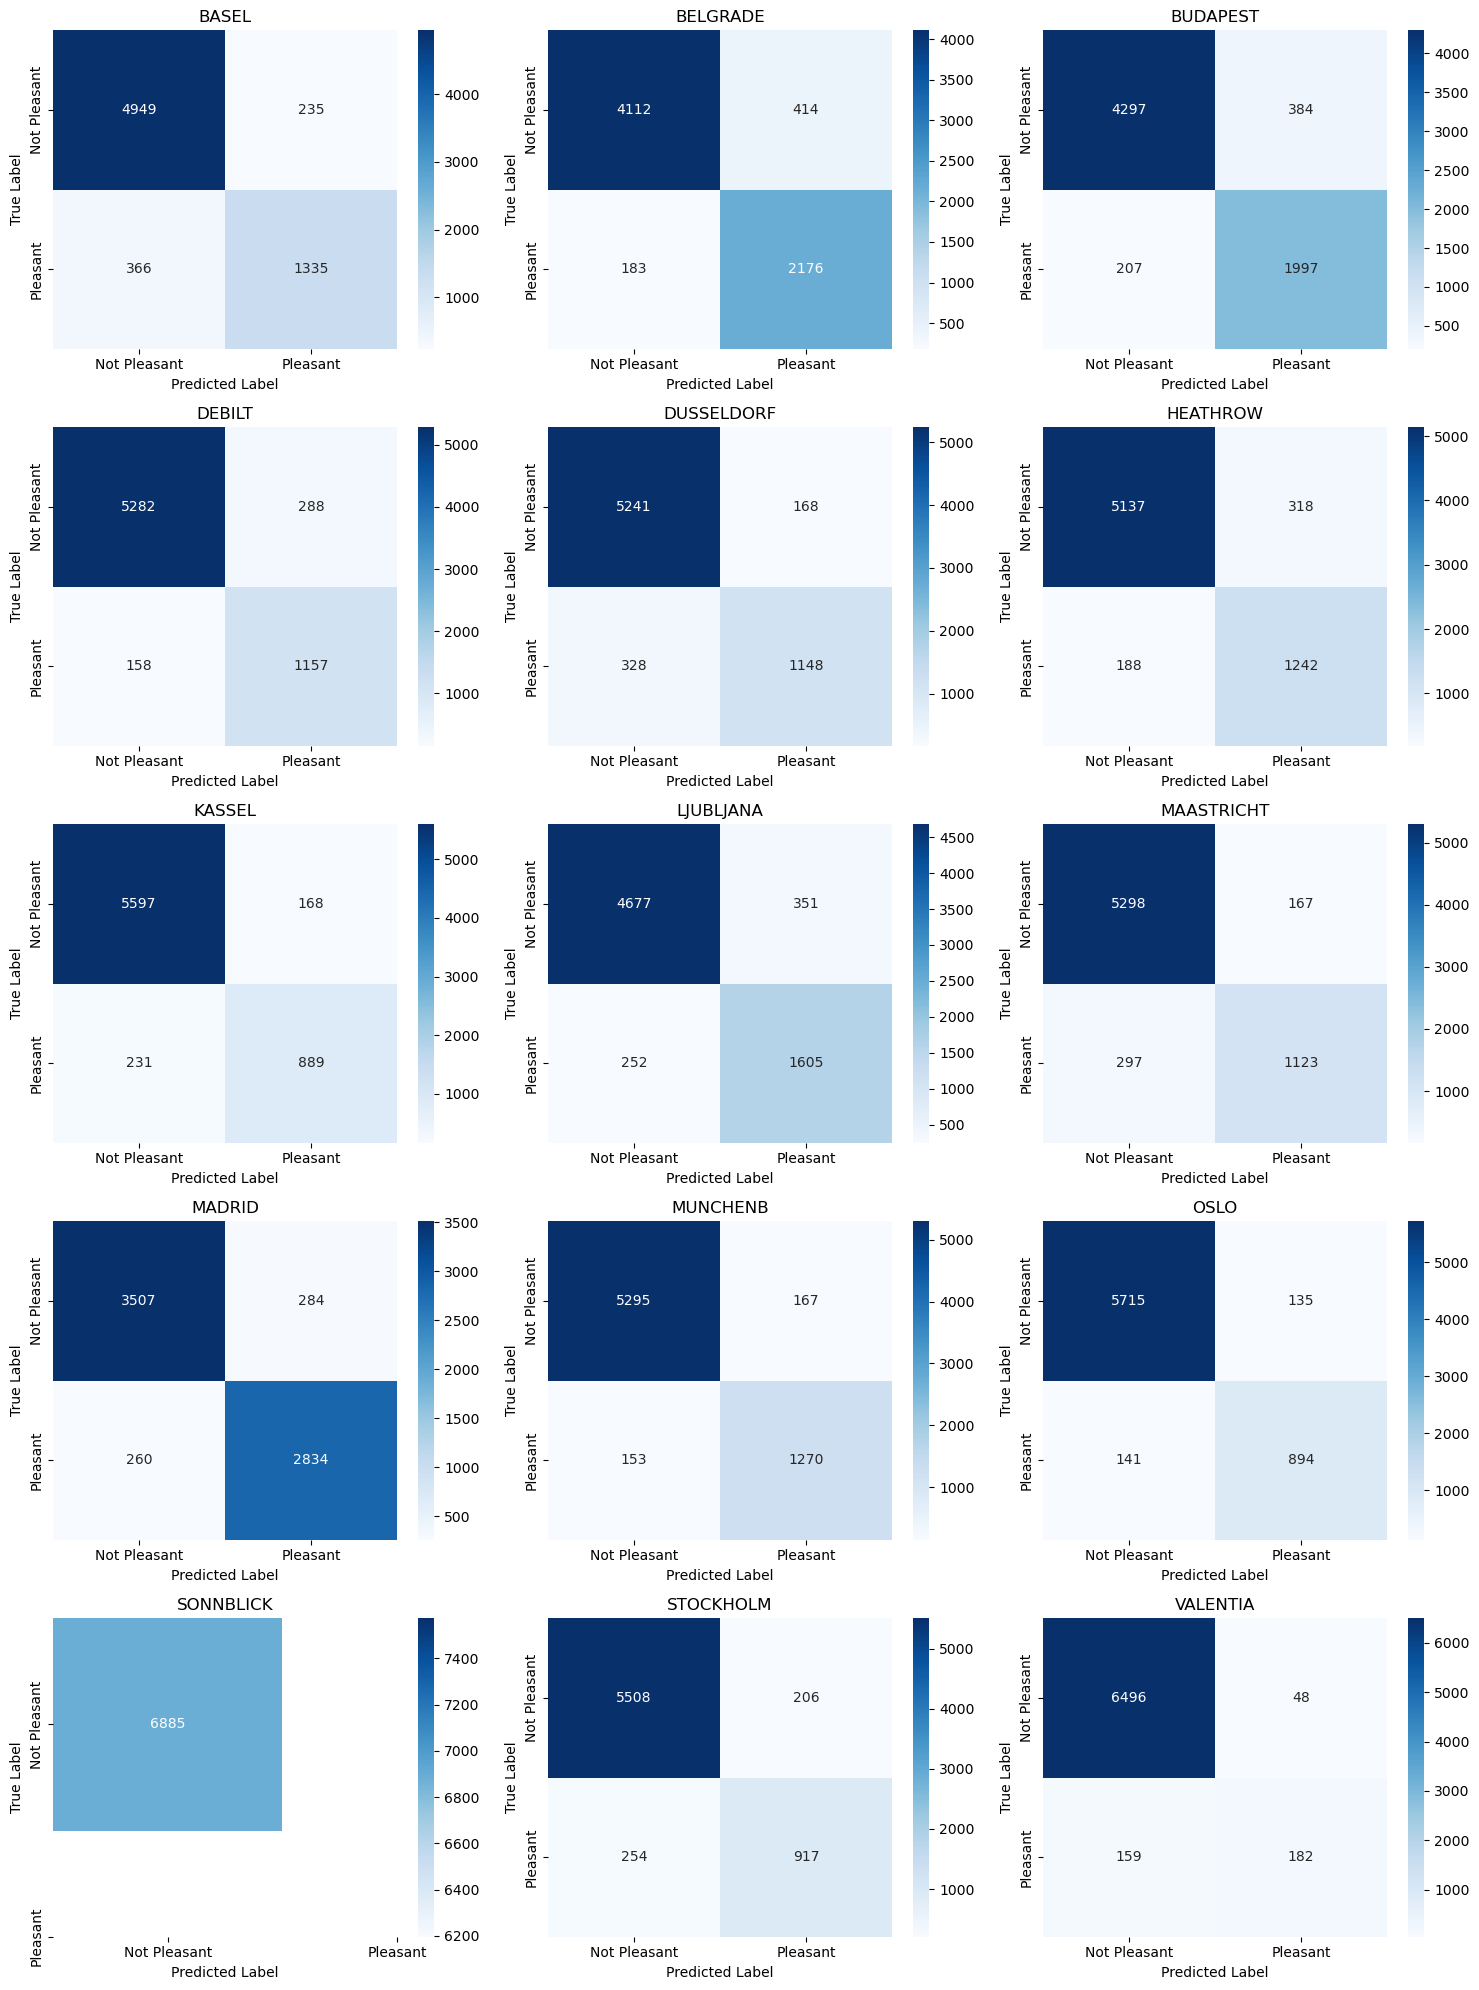

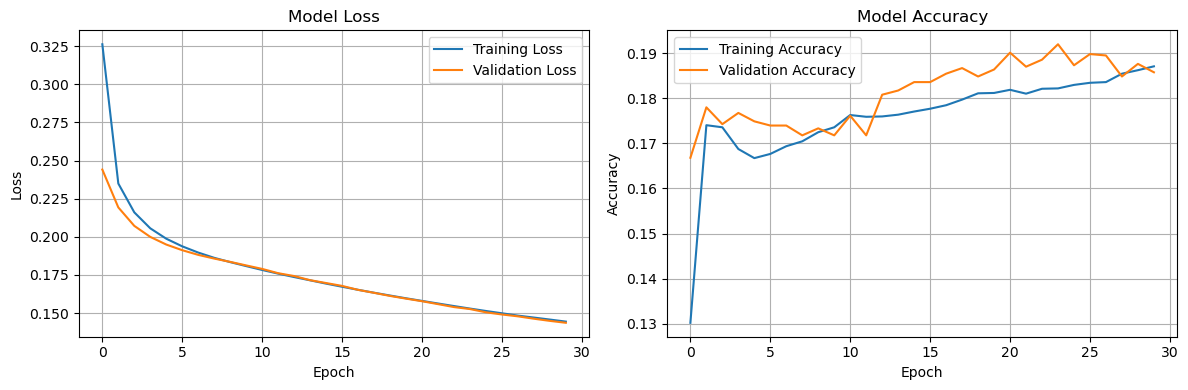

In [23]:
# ==============================================================================
# TASK 8: CREATE CONFUSION MATRIX
# ==============================================================================
print("\n" + "="*80)
print("TASK 8: CONFUSION MATRIX AND EVALUATION")
print("="*80)

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Station names for labels
stations = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 
            'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 
            'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

# Create confusion matrix for each station
print("\nConfusion Matrix per Station:")
print("-"*80)

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.ravel()

for i, station in enumerate(stations):
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Not Pleasant', 'Pleasant'],
                yticklabels=['Not Pleasant', 'Pleasant'])
    axes[i].set_title(f'{station}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')
    
    # Calculate accuracy for this station
    station_accuracy = np.sum(y_test[:, i] == y_pred_binary[:, i]) / len(y_test)
    print(f"{station:12s}: {station_accuracy:.2%} accuracy")

plt.tight_layout()
plt.savefig('/Users/davidscheider/anaconda_projects/ClimateWins/confusion_matrix_all_stations.png', 
            dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved: confusion_matrix_all_stations.png")

# Overall classification report
print("\n" + "-"*80)
print("OVERALL MODEL PERFORMANCE:")
print("-"*80)
print(f"Total predictions: {len(y_test) * 15:,}")
print(f"Correct predictions: {np.sum(y_test == y_pred_binary):,}")
print(f"Overall accuracy: {np.mean(y_test == y_pred_binary):.2%}")

# Check if model recognizes all 15 stations
stations_recognized = np.sum(y_pred_binary.sum(axis=0) > 0)
print(f"\nStations with at least one 'pleasant' prediction: {stations_recognized}/15")

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE")
print("="*80)
print("""
NEXT STEPS:
1. Save screenshots of:
   - Model summary
   - Training progress (loss/accuracy)
   - Final confusion matrices
   
2. Document hyperparameters in a separate file

3. Try adjusting hyperparameters to improve performance:
   - Increase epochs (50, 100)
   - Increase filters (64, 128)
   - Add more Conv1D layers
   - Adjust batch size (16, 64)
   
4. Save this script - you'll use it in Exercise 2.4!
""")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/Users/davidscheider/anaconda_projects/ClimateWins/training_history.png', 
            dpi=300, bbox_inches='tight')
print("\n✓ Training history plot saved: training_history.png")